In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D


ModuleNotFoundError: No module named 'cv2'

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()



In [ ]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)



In [ ]:

model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))# - Zahlen auf 0 setzen
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu')) # 128 Neuronen
model.add(tf.keras.layers.Dense(10, activation='softmax')) #alle zusammen = 1 jedes neuron hat eine Zahl zwischen 0 und 1. Probality of each digit

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
model.fit(x_train, y_train, epochs= 9) # 9 Epochen, bei 10 Epochen war eine schelchtere Accuracy
model.save('handwritten.model')



Epoch 1/9
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1647 - accuracy: 0.9482
Epoch 2/9
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0634 - accuracy: 0.9794
Epoch 3/9
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0380 - accuracy: 0.9880
Epoch 4/9
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0269 - accuracy: 0.9911
Epoch 5/9
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0199 - accuracy: 0.9935
Epoch 6/9
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0130 - accuracy: 0.9955
Epoch 7/9
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0144 - accuracy: 0.9952
Epoch 8/9
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0110 - accuracy: 0.9964
Epoch 9/9
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0085 - accuracy: 0.9974


INFO:tensorflow:Assets written to: handwritten.model\assets


INFO:tensorflow:Assets written to: handwritten.model\assets


In [ ]:
model = tf.keras.models.load_model('handwritten.model')
loss, accuracy = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0799 - accuracy: 0.9835


In [ ]:
def predicthandwritten(path): 
 img = cv2.imread(path)[:,:,0]
 img = np.invert(np.array([img]))
 prediction = model.predict(img)
 print(prediction)
 plt.imshow(img[0])
 plt.show()
 print(np.argmax(prediction))
 



313/313 [==============================] - 1s 3ms/step
9


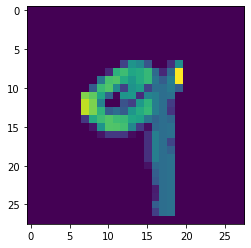

In [ ]:
predictions = model.predict(x_test)
print(np.argmax(predictions[322]))
plt.imshow(x_test[322])
plt.show()


1/1 [==============================] - 0s 15ms/step
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


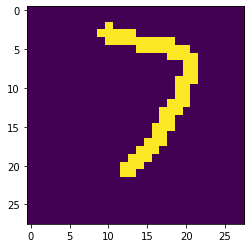

2


In [ ]:
predicthandwritten("7.png")

In [ ]:
prediction_labels = [np.argmax(i) for i in predictions]

confusionmatrix = tf.math.confusion_matrix(labels=y_test, predictions=prediction_labels)

plt.figure(figsize = (10, 7))
sn.heatmap(confusionmatrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')